In [3]:
import os

import torch
import torch.nn as nn
from torch import optim
import tensorflow as tf
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
import torch
from torchvision import transforms
from torchvision import datasets
from tensorflow import keras
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, recall_score,f1_score
import csv

/Users/boris/PycharmProjects/Programming/Yandex_liceum/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [71]:
# function below is a manual implementation of a one hot encoding
def onehot_encoding(x, column_name=None):
    classes_set = sorted(list(set(x)))
    classes_dict = dict()
    classes = 0
    for i in classes_set:
        if i not in classes_dict.keys():
            classes_dict[i] = classes
            classes += 1
    one_hot = np.zeros(shape=(len(x), classes))
    for i in range(len(x)):
        one_hot[i][classes_dict[x[i]]] = 1
    one_hot_column_names = np.array(one_hot.astype('float'))
    # encoded categorical features
    return one_hot_column_names
# image normalization
def normalize_images(imgs):
    return imgs/255.

In [72]:
class Dataset:
    def __init__(self,train_or_test):
        data=datasets.MNIST(root='mnist', download=True,train=train_or_test)
        self.x,self.y=data.data,np.array(data.targets)
        self.x=normalize_images(self.x)
        # self.y=onehot_encoding(self.y)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, item):
        return self.x[item],self.y[item]

In [73]:
# loading dataset
train=Dataset(train_or_test=True)
test=Dataset(train_or_test=False)
# answers
test.y

array([7, 2, 1, ..., 4, 5, 6])

In [74]:
# take a view on our dataset
def show_dataset(dataset_,dataset_labels_):
    # to show labels in convenient format
    figure = plt.figure(figsize=(6, 6))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        # to pick random images
        sample_idx = tf.random.uniform(shape=(1,), minval=0, maxval=len(dataset_), dtype=tf.int64).numpy()[0]
        # retrieve image name and it's labels
        img, label = dataset_[sample_idx],dataset_labels_[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

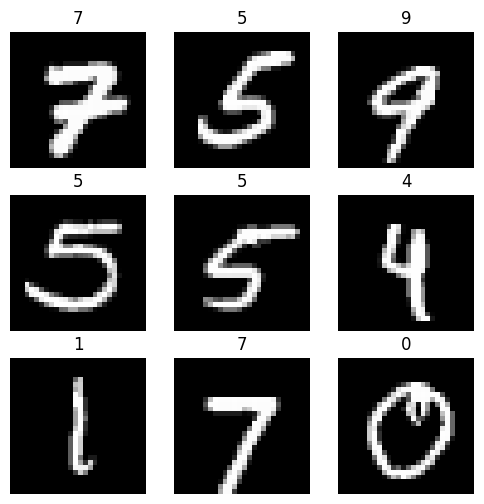

In [75]:
# take a view on dataset
show_dataset(train.x,train.y)

In [76]:
# batch_size=64
train_loader,test_loader=DataLoader(train,shuffle=True),DataLoader(test,shuffle=True)

In [77]:
loss_type=nn.CrossEntropyLoss()

In [11]:
def compute_precision_recall(matrix_):
    y_true,y_pred=[i[0] for i in matrix_],[i[1] for i in matrix_]
    # average = 'macro' => matrics are calculated across all classes for entire classification task
    precision=precision_score(y_true=y_true,y_pred=y_pred,average='macro')
    recall=recall_score(y_true=y_true,y_pred=y_pred,average='macro')
    f1_score_=f1_score(y_true=y_true,y_pred=y_pred,average='macro')
    return precision,recall,f1_score_

In [12]:
# drawing Confusion matrix for statistical analysis
def final_matrix(matrix,experiment,leng):
    my_matrix=torch.zeros(leng,leng,dtype=torch.int32).tolist()
    # fill the confusion matrix with values
    for i in matrix:
        my_matrix[i[0]][i[1]]+=1
    my_matrix=np.array(my_matrix)
    my_matrix=(my_matrix.T/my_matrix.sum(axis=1)).T
    my_matrix=np.round(my_matrix, 3)
    plt.figure(figsize=(30,36))
    # display matrix in blue colors
    disp = ConfusionMatrixDisplay(confusion_matrix=my_matrix, display_labels=range(10))
    disp.plot(cmap='Blues')
    # save to a folder
    plt.savefig(f'./Model_scores{experiment}/Confusion_matrix.jpg')
    plt.close()

In [13]:
def draw_plots(experiment,train_accuracy, test_accuracy, train_loss_, test_loss_):
    # To draw plots of accuracy and loss of train and test datasets
    plt.figure(figsize=(10, 7))
    plt.plot(train_accuracy, color='blue', linestyle='--',
             label='train accuracy')
    plt.plot(test_accuracy, color='red', linestyle='--',
             label='test accuracy')
    plt.ylabel = 'Accuracy'
    plt.xlabel = 'Epochs' 
    plt.legend()
    plt.savefig(f'./Model_scores{experiment}/accuracy.jpg')
    plt.close() 
    # Loss plot
    plt.figure(figsize=(10, 7))
    plt.plot(np.array(train_loss_), color='blue', linestyle='--',
             label='train loss')
    plt.plot(np.array(test_loss_), color='red', linestyle='--',
             label='test loss')
    plt.ylabel = 'Loss'     
    plt.xlabel = 'Epochs'   
    plt.legend()
    plt.savefig(f'./Model_scores{experiment}/loss.jpg')
    plt.close()    

In [14]:
def training_process(loader,my_model,optimize,loss,batch_size=1,):
    # turn on the training mode
    my_model.train()
    running_correct,epoch_loss=0,0
    epoch_accuracy=0
    for i, (images,labels) in tqdm(enumerate(loader), total=len(loader)):
            # gradients are reset to zero 
            optimize.zero_grad()
            outputs=my_model(images.view(-1,784))
            _,predictions=torch.max(outputs.data,1)
            loss_val=loss(outputs,labels)
            # backward pass 
            loss_val.backward()
            optimize.step()
            epoch_loss=loss_val/len(loader)
            running_correct+=(labels==predictions).sum().item()
            epoch_accuracy=100.*(running_correct/len(loader))
    return epoch_loss,round(epoch_accuracy/batch_size,6)

In [15]:
def evaluating_perfomance(loader_test,my_model,loss,last_epoch=False):
        with torch.no_grad():
            # variables to draw confusion matrix
            Confusion_list=[]
            running_correct,epoch_loss=0,0
            total=0
        #no updating loss
            for images,labels in loader_test:
                # flatten image to use it in the model
                outputs=my_model(images.view(-1,784))
                # compute loss on test dataset
                loss_val=loss(outputs,labels)
                # compute the loss and divide by the size of test dataset (10000)
                epoch_loss=loss_val/len(loader_test)
                for index,i in enumerate(outputs):
                    # torch.argmax(i) -> from the array of predictions extract the biggest one 
                    if torch.argmax(i)==labels[index]:
                        running_correct+=1
                    total+=1
                _,predicted_labels=torch.max(outputs.data,1)
                # after last epoch prepare data for Confusion matrix and graphs
                if last_epoch:
                    predicted_data=list(zip(labels.tolist(),predicted_labels.tolist()))
                    Confusion_list.extend(predicted_data)
            # if it is the last epoch --> return the list for confusion matrix
            if not last_epoch:
                return epoch_loss,100.*round(running_correct/total,6),[]
            else:
                return epoch_loss,100.*round(running_correct/total,6),Confusion_list

In [16]:
def make_directory(experiment):
    if f'Model_scores{experiment}' not in os.listdir('./'):
        os.mkdir(f"./Model_scores{experiment}")

In [17]:
def run_epochs(learning_rate=0.001,epochs=10,experiment_number=None,model_type=None,batch_size=1):
    optimizer=optim.SGD(model_type.parameters(),lr=learning_rate)
    criterion=nn.CrossEntropyLoss()
    # to track loss and accuracy after each epoch
    train_loss,testing_loss=[],[]
    train_acc,testing_acc=[],[]
    last_epoch=False
    for epoch in range(1,epochs+1):
            if epoch==epochs:
                last_epoch=True
            print(f"Epoch number: {epoch}")
            print()
            print('Training..')
            loss_,accuracy=training_process(loader=train_loader,my_model=model_type,optimize=optimizer,loss=criterion,batch_size=batch_size)
            train_loss.append(loss_)
            train_acc.append(accuracy)
            print(f'Training_Loss: {loss_} and Training_Accuracy: {accuracy} %')
            print('Testing..')
            loss_test,accuracy_test,confusion__matrix=evaluating_perfomance(loader_test=test_loader,my_model=model_type,loss=criterion,last_epoch=last_epoch)
            testing_loss.append(loss_test)
            testing_acc.append(accuracy_test)
            print(f'Testing_Loss: {loss_test} and Testing_Accuracy: {accuracy_test} %')
            print()
            print('-'*80)
            print()
    make_directory(experiment_number)
    # function that creates confusion matrix and saves it in a distinct folder
    final_matrix(confusion__matrix,experiment_number,leng=10)
    train_loss,testing_loss=[float(i) for i in train_loss],[float(i) for i in testing_loss]
    # draw plots of accuracy and loss
    draw_plots(experiment_number,train_accuracy=train_acc,train_loss_=np.array(train_loss),test_loss_=np.array(testing_loss),test_accuracy=testing_acc)
    # call function to compute precision and recall, f1 score
    precision,recall,f1_score_=compute_precision_recall(confusion__matrix)
    return {'precision':precision,'recall':recall,'f1_score':f1_score_,'accuracy':testing_acc[-1],'min_loss':min(testing_loss)}

In [18]:
# prepare csv file
file_name = "table.csv"
header = 'No\tModel_Number\tMin_Loss\tAccuracy\tprecision\trecall\tf1_score'
with open(file_name, 'w', newline='') as file_csv:
    file_csv.write(header + '\n')

In [19]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 50) 
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.final(x)
        return x

In [22]:
model1=Model()
model1

Model(
  (linear1): Linear(in_features=784, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [23]:
scores = run_epochs(experiment_number=1,model_type=model1)
print(scores)
experiment_number=1

Epoch number: 1

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4386.53it/s]


Training_Loss: 2.636444150994066e-06 and Training_Accuracy: 86.085 %
Testing..
Testing_Loss: 3.421467226871755e-06 and Testing_Accuracy: 91.74 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4382.76it/s]


Training_Loss: 1.6335202701611706e-07 and Training_Accuracy: 92.088333 %
Testing..
Testing_Loss: 2.0002851670142263e-05 and Testing_Accuracy: 93.17999999999999 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4437.40it/s]


Training_Loss: 1.5185289612418273e-06 and Training_Accuracy: 93.473333 %
Testing..
Testing_Loss: 2.764368900898262e-06 and Testing_Accuracy: 94.12 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4411.27it/s]


Training_Loss: 2.954141598010551e-09 and Training_Accuracy: 94.556667 %
Testing..
Testing_Loss: 5.9060526837129146e-05 and Testing_Accuracy: 94.66 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4312.44it/s]


Training_Loss: 1.0536756356316346e-08 and Training_Accuracy: 95.24 %
Testing..
Testing_Loss: 4.1874449379974976e-05 and Testing_Accuracy: 95.38 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4356.90it/s]


Training_Loss: 4.1185550969657925e-08 and Training_Accuracy: 95.745 %
Testing..
Testing_Loss: 2.0931496180764952e-07 and Testing_Accuracy: 95.71 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4389.95it/s]


Training_Loss: 3.497148099995684e-06 and Training_Accuracy: 96.193333 %
Testing..
Testing_Loss: 2.6782904569699895e-06 and Testing_Accuracy: 96.2 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4406.53it/s]


Training_Loss: 3.5293075484332803e-07 and Training_Accuracy: 96.521667 %
Testing..
Testing_Loss: 6.480985348389368e-07 and Testing_Accuracy: 96.21 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4394.07it/s]


Training_Loss: 7.006880332482979e-05 and Training_Accuracy: 96.776667 %
Testing..
Testing_Loss: 1.2965138296294754e-07 and Testing_Accuracy: 96.45 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:13<00:00, 4371.52it/s]


Training_Loss: 1.3074716775918205e-07 and Training_Accuracy: 96.905 %
Testing..
Testing_Loss: 3.45170541038442e-08 and Testing_Accuracy: 96.37 %

--------------------------------------------------------------------------------
{'precision': 0.9637137909648162, 'recall': 0.9633197330957746, 'f1_score': 0.9634205120339129, 'accuracy': 96.37, 'min_loss': 3.45170541038442e-08}


<Figure size 3000x3600 with 0 Axes>

In [24]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [25]:
# try to add one more hidden layer
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 50) 
        self.linear2 = nn.Linear(50, 30) 
        self.final = nn.Linear(30, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.final(x)
        return x

In [26]:
model2=Model()
model2

Model(
  (linear1): Linear(in_features=784, out_features=50, bias=True)
  (linear2): Linear(in_features=50, out_features=30, bias=True)
  (final): Linear(in_features=30, out_features=10, bias=True)
  (relu): ReLU()
)

In [27]:
scores = run_epochs(experiment_number=2,model_type=model2)
print(scores)
experiment_number=2

Epoch number: 1

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3774.31it/s]


Training_Loss: 2.4610231776023284e-05 and Training_Accuracy: 80.688333 %
Testing..
Testing_Loss: 9.752130836204742e-07 and Testing_Accuracy: 91.19 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3747.96it/s]


Training_Loss: 5.736571893066866e-06 and Training_Accuracy: 92.078333 %
Testing..
Testing_Loss: 1.4646275303675793e-06 and Testing_Accuracy: 93.31 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3592.22it/s]


Training_Loss: 2.6398940462968312e-05 and Training_Accuracy: 93.878333 %
Testing..
Testing_Loss: 3.276220752468362e-07 and Testing_Accuracy: 94.55 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3789.25it/s]


Training_Loss: 2.0646176324135013e-08 and Training_Accuracy: 95.265 %
Testing..
Testing_Loss: 1.988935025565297e-07 and Testing_Accuracy: 95.63000000000001 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3752.76it/s]


Training_Loss: 1.9968453557339672e-07 and Training_Accuracy: 95.991667 %
Testing..
Testing_Loss: 3.981079498771578e-05 and Testing_Accuracy: 96.16 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3821.06it/s]


Training_Loss: 1.9601397980295587e-06 and Training_Accuracy: 96.635 %
Testing..
Testing_Loss: 6.043728184579322e-09 and Testing_Accuracy: 96.17 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3791.05it/s]


Training_Loss: 4.73798742461895e-08 and Training_Accuracy: 96.926667 %
Testing..
Testing_Loss: 4.649151341684643e-10 and Testing_Accuracy: 96.8 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:16<00:00, 3698.20it/s]


Training_Loss: 6.859973495920713e-07 and Training_Accuracy: 97.32 %
Testing..
Testing_Loss: 6.8423791077520946e-09 and Testing_Accuracy: 96.97 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3822.32it/s]


Training_Loss: 1.2847762036471977e-06 and Training_Accuracy: 97.638333 %
Testing..
Testing_Loss: 9.915208465827163e-06 and Testing_Accuracy: 97.04 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:15<00:00, 3821.64it/s]


Training_Loss: 2.554484446193328e-08 and Training_Accuracy: 97.756667 %
Testing..
Testing_Loss: 9.954979418580479e-08 and Testing_Accuracy: 97.36 %

--------------------------------------------------------------------------------

{'precision': 0.9734186650592391, 'recall': 0.9733782476143213, 'f1_score': 0.9733724775248902, 'accuracy': 97.36, 'min_loss': 4.649151341684643e-10}


<Figure size 3000x3600 with 0 Axes>

In [28]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [78]:
# let's add one more layer + increase the number of neurons in each layer
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 150) 
        self.linear3=nn.Linear(150,50)
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()
        self.tanh=nn.Tanh()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.tanh(self.linear3(x))
        x = self.final(x)
        return x

In [79]:
model3=Model()
model3

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=150, bias=True)
  (linear3): Linear(in_features=150, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [80]:
scores = run_epochs(experiment_number=3,model_type=model3,epochs = 11)
print(scores)
experiment_number=3

Epoch number: 1

Training..


100%|██████████| 60000/60000 [00:23<00:00, 2506.56it/s]


Training_Loss: 1.019811043079244e-05 and Training_Accuracy: 80.218333 %
Testing..
Testing_Loss: 3.896583166351775e-06 and Testing_Accuracy: 91.53 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:23<00:00, 2541.52it/s]


Training_Loss: 1.887245275611349e-07 and Training_Accuracy: 92.945 %
Testing..
Testing_Loss: 3.413922797790292e-07 and Testing_Accuracy: 94.26 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:23<00:00, 2547.49it/s]


Training_Loss: 4.931880539515987e-05 and Training_Accuracy: 95.108333 %
Testing..
Testing_Loss: 1.136015086444786e-07 and Testing_Accuracy: 95.47 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:20<00:00, 2878.31it/s]


Training_Loss: 2.4229548145626723e-08 and Training_Accuracy: 96.306667 %
Testing..
Testing_Loss: 2.3428155770943704e-07 and Testing_Accuracy: 96.07 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:21<00:00, 2800.61it/s]


Training_Loss: 4.9032095716938784e-08 and Training_Accuracy: 96.95 %
Testing..
Testing_Loss: 8.084549563136534e-07 and Testing_Accuracy: 96.67999999999999 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:21<00:00, 2728.78it/s]


Training_Loss: 2.0600536387860302e-08 and Training_Accuracy: 97.473333 %
Testing..
Testing_Loss: 2.1991675112076337e-06 and Testing_Accuracy: 97.09 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:21<00:00, 2734.23it/s]


Training_Loss: 1.2390930237415887e-07 and Training_Accuracy: 97.875 %
Testing..
Testing_Loss: 5.2926836247024767e-08 and Testing_Accuracy: 97.18 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:22<00:00, 2669.09it/s]


Training_Loss: 1.8564451309543983e-08 and Training_Accuracy: 98.19 %
Testing..
Testing_Loss: 4.9626432740979e-08 and Testing_Accuracy: 97.35000000000001 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:22<00:00, 2619.35it/s]


Training_Loss: 1.0191173771545436e-07 and Training_Accuracy: 98.418333 %
Testing..
Testing_Loss: 9.738924333646537e-09 and Testing_Accuracy: 97.25 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:24<00:00, 2433.01it/s]


Training_Loss: 5.004633152339011e-08 and Training_Accuracy: 98.61 %
Testing..
Testing_Loss: 2.0621081731064805e-08 and Testing_Accuracy: 97.39 %

--------------------------------------------------------------------------------

Epoch number: 11

Training..


100%|██████████| 60000/60000 [00:22<00:00, 2623.07it/s]


Training_Loss: 4.642555229139589e-09 and Training_Accuracy: 98.828333 %
Testing..
Testing_Loss: 2.4899721395854613e-08 and Testing_Accuracy: 97.41 %

--------------------------------------------------------------------------------
{'precision': 0.9739304440197752, 'recall': 0.9742359118257131, 'f1_score': 0.9740127152071614, 'accuracy': 97.41, 'min_loss': 9.738924333646537e-09}


<Figure size 3000x3600 with 0 Axes>

In [81]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [33]:
# implement dropout technique
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.dropout=nn.Dropout(0.2)
        self.final = nn.Linear(50, 10)
        self.relu = nn.ReLU()

    def forward(self, img): #convert + flatten
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.relu(self.dropout(self.linear2(x)))
        x = self.final(x)
        return x

In [34]:
model4=Model()
model4

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [35]:
scores = run_epochs(experiment_number=4,model_type=model4)
print(scores)
experiment_number=4

Epoch number: 1

Training..


100%|██████████| 60000/60000 [00:19<00:00, 3142.29it/s]


Training_Loss: 2.137114961442421e-06 and Training_Accuracy: 78.85 %
Testing..
Testing_Loss: 1.3603836350739584e-06 and Testing_Accuracy: 90.59 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3422.57it/s]


Training_Loss: 1.7804139815780218e-06 and Training_Accuracy: 91.298333 %
Testing..
Testing_Loss: 3.6877264619761263e-07 and Testing_Accuracy: 92.65 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3460.13it/s]


Training_Loss: 1.446133950366857e-07 and Training_Accuracy: 93.606667 %
Testing..
Testing_Loss: 1.1065191074521863e-06 and Testing_Accuracy: 94.3 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3474.37it/s]


Training_Loss: 2.670807361937477e-07 and Training_Accuracy: 94.958333 %
Testing..
Testing_Loss: 9.701957424113061e-07 and Testing_Accuracy: 95.38 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3383.81it/s]


Training_Loss: 3.92356423617457e-06 and Training_Accuracy: 95.688333 %
Testing..
Testing_Loss: 2.7681389269673673e-07 and Testing_Accuracy: 95.81 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3224.63it/s]


Training_Loss: 1.04430807823519e-06 and Training_Accuracy: 96.413333 %
Testing..
Testing_Loss: 1.531859879833064e-06 and Testing_Accuracy: 96.23 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3185.80it/s]


Training_Loss: 4.188317248576823e-08 and Training_Accuracy: 96.875 %
Testing..
Testing_Loss: 6.221688408913906e-07 and Testing_Accuracy: 96.0 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3201.83it/s]


Training_Loss: 2.218162222789033e-07 and Training_Accuracy: 97.161667 %
Testing..
Testing_Loss: 1.7285197717598066e-09 and Testing_Accuracy: 96.75 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3290.82it/s]


Training_Loss: 4.967046218773419e-11 and Training_Accuracy: 97.351667 %
Testing..
Testing_Loss: 1.9236204025219195e-06 and Testing_Accuracy: 96.86 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3409.37it/s]


Training_Loss: 7.218545215437189e-05 and Training_Accuracy: 97.62 %
Testing..
Testing_Loss: 2.562966727737148e-09 and Testing_Accuracy: 96.89 %

--------------------------------------------------------------------------------
{'precision': 0.9685882840193056, 'recall': 0.9687336477945326, 'f1_score': 0.968615913397682, 'accuracy': 96.89, 'min_loss': 1.7285197717598066e-09}


<Figure size 3000x3600 with 0 Axes>

In [36]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [45]:
# model type -> without dropout, but replacing RELU with softmax
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.final = nn.Linear(50, 10) 
        self.relu=nn.ReLU()
        self.softmax = nn.Softmax()
        self.tanh=nn.Tanh()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.linear1(x))
        x = self.tanh(self.linear2(x))
        x = self.softmax(self.final(x))
        return x

In [46]:
model5=Model()
model5

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
  (tanh): Tanh()
)

In [47]:
scores = run_epochs(experiment_number=5,model_type=model5)
print(scores)
experiment_number=5

Epoch number: 1

Training..


  0%|          | 0/60000 [00:00<?, ?it/s]/Users/boris/PycharmProjects/Programming/Yandex_liceum/lib/python3.9/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
100%|██████████| 60000/60000 [00:18<00:00, 3220.78it/s]


Training_Loss: 2.678382043086458e-05 and Training_Accuracy: 41.158333 %
Testing..
Testing_Loss: 0.00015809772594366223 and Testing_Accuracy: 68.97999999999999 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3303.15it/s]


Training_Loss: 2.441619108140003e-05 and Training_Accuracy: 83.778333 %
Testing..
Testing_Loss: 0.00015042844461277127 and Testing_Accuracy: 89.02 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3193.64it/s]


Training_Loss: 2.444548772473354e-05 and Training_Accuracy: 89.763333 %
Testing..
Testing_Loss: 0.00024230856797657907 and Testing_Accuracy: 90.84 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3315.70it/s]


Training_Loss: 2.436532849969808e-05 and Training_Accuracy: 91.01 %
Testing..
Testing_Loss: 0.00014620051661040634 and Testing_Accuracy: 92.01 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3271.71it/s]


Training_Loss: 2.4519700673408806e-05 and Training_Accuracy: 91.916667 %
Testing..
Testing_Loss: 0.00014621787704527378 and Testing_Accuracy: 92.42 %

--------------------------------------------------------------------------------

Epoch number: 6

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3256.66it/s]


Training_Loss: 2.4651675630593672e-05 and Training_Accuracy: 92.623333 %
Testing..
Testing_Loss: 0.00014611765800509602 and Testing_Accuracy: 92.94 %

--------------------------------------------------------------------------------

Epoch number: 7

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3293.22it/s]


Training_Loss: 3.049825863854494e-05 and Training_Accuracy: 93.146667 %
Testing..
Testing_Loss: 0.00014616931730415672 and Testing_Accuracy: 93.12 %

--------------------------------------------------------------------------------

Epoch number: 8

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3297.05it/s]


Training_Loss: 2.4353548724320717e-05 and Training_Accuracy: 93.628333 %
Testing..
Testing_Loss: 0.0001461416541133076 and Testing_Accuracy: 93.67999999999999 %

--------------------------------------------------------------------------------

Epoch number: 9

Training..


100%|██████████| 60000/60000 [00:17<00:00, 3334.09it/s]


Training_Loss: 2.4353174012503587e-05 and Training_Accuracy: 94.023333 %
Testing..
Testing_Loss: 0.00015637357137165964 and Testing_Accuracy: 93.84 %

--------------------------------------------------------------------------------

Epoch number: 10

Training..


100%|██████████| 60000/60000 [00:18<00:00, 3237.15it/s]


Training_Loss: 2.4370594474021345e-05 and Training_Accuracy: 94.388333 %
Testing..
Testing_Loss: 0.00014625914627686143 and Testing_Accuracy: 94.28999999999999 %

--------------------------------------------------------------------------------
{'precision': 0.9425493863358512, 'recall': 0.941988879764159, 'f1_score': 0.9420696523984187, 'accuracy': 94.28999999999999, 'min_loss': 0.00014611765800509602}


<Figure size 3000x3600 with 0 Axes>

In [51]:
with open(file_name,'a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})

In [52]:
batch_size=32
train_loader,test_loader=DataLoader(train,shuffle=True,batch_size=batch_size),DataLoader(test,shuffle=True,batch_size=batch_size)

In [53]:
# Last model type -> without dropout, but replacing RELU with softmax + batch normalization
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.linear1 = nn.Linear(28*28, 100) 
        self.linear2 = nn.Linear(100, 50) 
        self.batch1=nn.BatchNorm1d(100)
        self.batch2=nn.BatchNorm1d(50)
        self.final = nn.Linear(50, 10) 
        self.relu = nn.ReLU()
        self.tanh=nn.Tanh()

    def forward(self, img):
        x = img.view(-1, 28*28)
        x = self.relu(self.batch1(self.linear1(x)))
        x = self.tanh(self.batch2(self.linear2(x)))
        x = self.final(x)
        return x

In [54]:
model6=Model()
model6

Model(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (batch1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (final): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
  (tanh): Tanh()
)

In [57]:
# I will illustrate only 5 epochs to not make the file infinitely long
scores = run_epochs(experiment_number=6,model_type=model6,epochs=5,batch_size=batch_size)
print(scores)
experiment_number=6

Epoch number: 1

Training..


100%|██████████| 1875/1875 [00:03<00:00, 610.50it/s]


Training_Loss: 0.00015933990653138608 and Training_Accuracy: 95.266667 %
Testing..
Testing_Loss: 0.0002408335858490318 and Testing_Accuracy: 94.93 %

--------------------------------------------------------------------------------

Epoch number: 2

Training..


100%|██████████| 1875/1875 [00:03<00:00, 604.38it/s]


Training_Loss: 4.5327575207920745e-05 and Training_Accuracy: 95.428333 %
Testing..
Testing_Loss: 0.0003675913321785629 and Testing_Accuracy: 95.44 %

--------------------------------------------------------------------------------

Epoch number: 3

Training..


100%|██████████| 1875/1875 [00:03<00:00, 603.38it/s]


Training_Loss: 0.0001442652865080163 and Training_Accuracy: 95.69 %
Testing..
Testing_Loss: 0.0006104353815317154 and Testing_Accuracy: 95.39 %

--------------------------------------------------------------------------------

Epoch number: 4

Training..


100%|██████████| 1875/1875 [00:03<00:00, 611.57it/s]


Training_Loss: 0.00011788538540713489 and Training_Accuracy: 95.915 %
Testing..
Testing_Loss: 0.0016054214211180806 and Testing_Accuracy: 95.27 %

--------------------------------------------------------------------------------

Epoch number: 5

Training..


100%|██████████| 1875/1875 [00:03<00:00, 604.44it/s]


Training_Loss: 6.705954001517966e-05 and Training_Accuracy: 96.125 %
Testing..
Testing_Loss: 0.0019980098586529493 and Testing_Accuracy: 95.72 %

--------------------------------------------------------------------------------
{'precision': 0.9569078869811447, 'recall': 0.9569457172093465, 'f1_score': 0.9569110046860236, 'accuracy': 95.72, 'min_loss': 0.0002408335858490318}


<Figure size 3000x3600 with 0 Axes>

In [58]:
with open('table.csv','a',newline='') as file_csv:
    writer_ = csv.DictWriter(file_csv, fieldnames=header.split('\t'),delimiter='\t')
    writer_.writerow({'No':experiment_number,'Model_Number':f'model{experiment_number}','Min_Loss':scores['min_loss'],'Accuracy':scores['accuracy']/100,'precision':scores['precision'],'recall':scores['recall'],'f1_score':scores['f1_score']})